# Introduction to Python using Turing patterns

## 1. Introduction
**First of, within this course [this page](https://docs.python.org/3/tutorial/index.html) will be mentioned a lot. It is a really good (maybe a bit crude) source for informations and it is the official Python page so it is also quite accurate.**

### 1.1 Goal of this course
This course aim at teaching the basics of coding using reaction diffusion simulations as a support, more specifically the Turing patterns.
The mathematics or the biology behind the Turing patterns is not necessary but it might help to understand better what is happening behind the hood.

At the end of the course, we would like you to be able to write small pieces of code to do basic data analysis.
No computation level is required though it is good to keep in mind that at the time being, this notebook alone might not be enough: the teachers are still necessary (unfortunately?) to introduce the concepts and to help answering the potential questions.

### 1.2 Turing patterns
Now about Turing patterns, they were introduced by Alan Turing in the article [The Chemical Basis of Morphogenesis](https://www.dna.caltech.edu/courses/cs191/paperscs191/turing.pdf).
They will not been much discussed here but fill free to ask questions or to look over [there](https://en.wikipedia.org/wiki/Reaction%E2%80%93diffusion_system) for more information.

What is important to keep in mind is that a Turing pattern is the result of the interaction between an activator and its inhibitor and their co-diffusion across a set of cells.

It is this interaction and diffusion that we will model in this course. We will also learn how to represent these patterns.

A little bit of knowledge about how to model these interactions is necessary to better understand the remaining of the course.
First, we will be talking about an activator that will name $A$ and an inhibitor that will name $I$. Their concentration values will be refered to as $a$ and $i$ respectively.

The gene regulation network that we are considering here is the simple one where $A$ auto-activates and activates $I$ and $I$ inhibits $A$:

<img src="Images/GRN.png" alt="Gene Regulation Network" width="200"/>

> _**To go a little bit further (not required):**_
> 
> From this network, we can extrat the interaction between activator $A$ and an inhibitor $I$ as follow:
> 
> $A \rightarrow A$ ($A$ is auto activated)
> 
> $A \rightarrow I$ ($A$ activates $I$)
> 
> $I \dashv A$ ($I$ inhibits $A$)
> 
> These interactions can be modeled multiple ways.
> We decided here to use the [FitzHugh–Nagumo model](https://en.wikipedia.org/wiki/FitzHugh%E2%80%93Nagumo_model) (for no particular reason) resulting in the following equations:
> 
> $\frac{\delta a}{\delta t} = d_a\Delta a + a - a^3 - i + k$ [1]
> 
> $\tau \frac{\delta i}{\delta t} = d_i\Delta i + a - i$ [2]
> 
> These are partial differential equations that represent the change of concentration of $A$ ($\delta a$) or $I$ ($\delta i$) when the time changes by a small amount ($\delta t$).
>
> In equation [1], $\Delta a$ is the potential diffusion $A$ and $d_a$ is the diffusion coefficient.
> $+ a$ is the auto-activation of $A$, $-a^3$ is the degradation, $-i$ is the inhibition from $I$ and $k$ is a constant.
>
> In equation [2], $\Delta i$ is the potential diffusion of $I$ and $d_i$ is the diffusion coefficient.
> $+a$ is the activation from $A$ and $-i$ is the degradation.

It is important to know that to model the previous network it is necessary to decide on some values, the parameters of the model:
- the diffusion coefficients $d_a$ and $d_i$ (refered to as `d_a` and `d_i` in the code)
- the constant $\tau$ (refered to as `tau`)
- the constant $k$ (refered to as `k`)

Moreover other values are necessary for the computation also need to be decided:
- the size of the grid we will be working on (`size`)
- the distance between two cells (ie the space step: `dx` and `dy`)
- the total time of the simulation (`T`)
- the time step for the simulation (`dt`)
- the number of iterations (`n`, which is determined by the ratio of `T` over `dt`)

---

## 2. Variables
Variables are symbolic names where information or values can be stored.

They are the cornerstone of coding, they allow to store in memory values and to access them later on. In our example the variables have been decribed earlier (`d_a`, `tau`, `size`, ...)

To assign an information to a variable, the `=` operator is used.

---
⚠️ be careful, `=` is the assignment operator. To check the equality between two variables, the required operator is `==` ⚠️

---

For example after the following line of code is ran:

In [29]:
a_number = 0
a_number = 10
another_number = 1

The variable `a_number` used to contain the value `0` and now contains the value `10`.

The variable `another_number` contains the values `1`.

It is possible to display what is contained in a variable using the fuction `print` for example:

In [30]:
print(f'a_number --> {a_number}')

a_number --> 10


The content of a variable can be stored in another variable and then changed without altering it:

In [31]:
a_number = 5
another_number = a_number
a_number = 1
print(f'another_number --> {another_number}')
print(f'a_number --> {a_number}')

another_number --> 5
a_number --> 1


Variables can contain most (computational) things (especially in Python).
For example they can contain different types of data such as `list`, `dictionary` or `ndarray` (we will see what they are right after)

### 2.1 Exercices:
Before any exercice, import the `Correction` module which allows you to check out the correction of the exercices the following way:
```python
Correction(<exo_num>)
```
You can import the function as shown just bellow. It needs to be imported only once.

In [32]:
from Resources.Answers import answer

#### Exercice 1
Set the value of the variables necessary for the model as follow:
- a: 0.0002.8
- b: 0.005
- tau: 0.1
- k: -0.005
- size: 100 
- dx: 2 divided by the size of the grid
- T: 9
- dt: 0.001
- n: number of iterations which is the total time `T` divided by the time step `dt`

In [33]:
### Write the answer of the previous question here.
# You can check the answer by running answer(1)

#### Exercice 2
Given a variable `nb1` and a variable `nb2`, put the values of each other variables in the other one

(Note that we are using the library `random` to generate random numbers)

In [34]:
from random import randint # To generate random numbers so you can't really cheat
nb1 = randint(0, 5)
nb2 = randint(6, 10)
print(f'nb1 before: {nb1}')
print(f'nb2 before: {nb2}')
'''
To do: swap a and b values
'''
print(f'nb1 after: {nb1}')
print(f'nb2 after: {nb2}')

nb1 before: 3
nb2 before: 10
nb1 after: 3
nb2 after: 10


---

## 3. Data structures
When coding, different type of data structures can be used. For example we already saw few types of data:
- Integers (refered to as `int` in Python): `0`, `1`, `-10`, ...
- Floating numbers (refered to as `float` in Python): `0.01`, `1.0`, `1.2e10`, ...
- Strings (refered to as `str` in Python): `'Hello'`, `"world"`, `'12+34'`, ...

But of course other data types exist:
- Lists (`list`): `[1, 2, 3]`, `[1, None, 0.4]`, `[1, [1, 2], [3], ['Hello'], 'World']`, ...
- Tuples (`tuple`): `(1, 2, 3)`, `(1, None, 0.4)`, ...
- Dictionaries (`dict`): `{'a': 10, 3:[2, 3, 4], '5': -0.2}`, ...

### 3.1 The lists: `list`
As their name suggest a `list` allows to store a list of elements. These elements can then be accessed via their position, starting at `0`.

There is a lot of possible operations on lists that can be found [there](https://docs.python.org/3/tutorial/datastructures.html#more-on-lists)

The Python language is so that a `list` is surrounded by brackets:

In [35]:
l1 = [1, 2, 3, 4]
print(f'l1    --> {l1}')
print(f'positions: 0  1  2  3')
print(f'l1[0] --> {l1[0]}')
print(f'l1[3] --> {l1[3]}')

l1    --> [1, 2, 3, 4]
positions: 0  1  2  3
l1[0] --> 1
l1[3] --> 4


It is also possible to access to the values in a list using negative numbers, `-1` being the last element, `-2` the one before last and so on and so forth:

In [36]:
print(f'l1     --> {l1}')
print(f'positions: -4 -3 -2 -1')
print(f'l1[-1] --> {l1[-1]}')
print(f'l1[-3] --> {l1[-3]}')

l1     --> [1, 2, 3, 4]
positions: -4 -3 -2 -1
l1[-1] --> 4
l1[-3] --> 2


It is also possible to access to part of the list, it is called a slice.

To do so the syntax is the following:
```
list[start:stop:step]
```
`start` is included, `stop` is not, `step` is the step size.

In [37]:
l1 = list(range(3, 13))
print(f'l1        --> {l1}')
print(f'positions --> {list(range(len(l1)))}')
print(f'l1[3:7]   --> {l1[3:7]}')
print(f'l1[:2]    --> {l1[:2]}')
print(f'l1[6:]    --> {l1[6:]}')
print(f'l1[1:7:2] --> {l1[1:7:2]}')

l1        --> [3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
positions --> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
l1[3:7]   --> [6, 7, 8, 9]
l1[:2]    --> [3, 4]
l1[6:]    --> [9, 10, 11, 12]
l1[1:7:2] --> [4, 6, 8]


A `list` can be modified by adding values into them using the method `append`:

In [38]:
l1 = [1, 2, 3, 4]
print(f'l1    --> {l1}')
l1.append('hello')
print(f'l1    --> {l1}')
print(f'l1[4] --> {l1[4]}')

l1    --> [1, 2, 3, 4]
l1    --> [1, 2, 3, 4, 'hello']
l1[4] --> hello


They can also be modified by removing elements from it using the method `pop` which removes the last element of the list by default:

In [39]:
l1 = [1, 2, 3, 4]
print(f'l1    --> {l1}')
l1.pop()
print(f'l1    --> {l1}')

l1    --> [1, 2, 3, 4]
l1    --> [1, 2, 3]


By removing a specific element of the list using the method `remove`:

In [40]:
l1 = [4, 5, 6, 7]
print(f'l1    --> {l1}')
l1.remove(5)
print(f'l1    --> {l1}')

l1    --> [4, 5, 6, 7]
l1    --> [4, 6, 7]


Or by modifying already existing values by accessing them:

In [41]:
l1 = [1, 2, 3, 4]
print(f'l1 --> {l1}')
l1[1] = 3
print(f'l1 --> {l1}')
l1[2] = l1[0]+1
print(f'l1 --> {l1}')

l1 --> [1, 2, 3, 4]
l1 --> [1, 3, 3, 4]
l1 --> [1, 3, 2, 4]


Two lists can be concatenated togheter either by using the method `extend` or the `+` operator.

⚠️ It is important to remember that the `extend` method is performed 'in place' meaning that it modifies the list from which it is called from ⚠️

In [42]:
l1 = [1, 2, 3, 4]
l2 = ['a', 'b', 'c', 'd']
l3 = l1 + l2
print(f'l3 --> {l3}')
l1.extend(l2)
print(f'l1 --> {l1}')
l4 = l1 + l2
print(f'l4 --> {l4}')

l3 --> [1, 2, 3, 4, 'a', 'b', 'c', 'd']
l1 --> [1, 2, 3, 4, 'a', 'b', 'c', 'd']
l4 --> [1, 2, 3, 4, 'a', 'b', 'c', 'd', 'a', 'b', 'c', 'd']


### 3.2 The dictionaries: `dict`
A dictionary is a data structure that maps a key to a value. It is somewhat similar to a `list` except that instead of refering to a value by its position in the `list` it is refered to by its key.

Dictonaries are defined using curved brackets `{`:

In [43]:
d1 = {4: '1', '3':'Hello'}
print(f'd1      --> {d1}')
print(f'd1[4]   --> {d1[4]}')
print(f'd1[\'3\'] --> {d1["3"]}')

d1      --> {4: '1', '3': 'Hello'}
d1[4]   --> 1
d1['3'] --> Hello


For reasons that we will not explain here, a `list` cannot be used as a key for a dictionary (though it can be used as values):

In [44]:
d1 = {1: [1, 2, 3, 4], 4:4}
print(f'd1 --> {d1}')

d1 --> {1: [1, 2, 3, 4], 4: 4}


In [45]:
try:
    d1 = {[1, 2]: 1}
except Exception as e:
    print(f'The error was:\n\t{e}')

The error was:
	unhashable type: 'list'


Dictionaries can be modified but cannot be sliced (since there is no explicit order on the keys):

In [46]:
d1 = {1: [1, 2, 3, 4], 4:4}
print(f'd1 --> {d1}')
d1[3] = 5
print(f'd1 --> {d1}')

d1 --> {1: [1, 2, 3, 4], 4: 4}
d1 --> {1: [1, 2, 3, 4], 4: 4, 3: 5}


You can find more information about dictionaries [there](https://docs.python.org/3/tutorial/datastructures.html#dictionaries)

### 3.3 The numpy arrays `ndarray`
A very useful data structure is the `ndarray` from [NumPy](https://numpy.org/). It is usually very fast and allows you to manipulate arrays of $n$ dimensions (hence the name).

`ndarray` are complex data structures and we will not go in depth into what you can do with them here, we will only look at what we need along the class.
> _**To go a little bit further (not required):**_
>
> You can find more information about `ndarray`s [there](https://numpy.org/doc/stable/reference/arrays.ndarray.html)
>
> If you want to learn interactively about `ndarray`s, you can check out the [following exercices](https://www.machinelearningplus.com/python/101-numpy-exercises-python/).

Note that the previous exercices are not required but they could be very useful for the following classes.

To use `ndarray`s, it is necessary to load the NumPy library (and therefore for it to be installed): 

In [47]:
import numpy as np

Then, one can create a `ndarray` the following ways (note that many other ways exist):

In [48]:
arr1 = np.array([[1, 2, 3], [2, 3, 4]]) # Create an array from a list
arr2 = np.zeros((4, 4))                 # Create an array filled with 0s of size 4x4
arr3 = np.arange(10)                    # Create a 1d array with values from 0 to 9
print(f'arr1 -->\n{arr1}')
print(f'arr2 -->\n{arr2}')
print(f'arr3 -->\n{arr3}')

arr1 -->
[[1 2 3]
 [2 3 4]]
arr2 -->
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
arr3 -->
[0 1 2 3 4 5 6 7 8 9]


`ndarray`s are useful because many operations can be performed on them in a direct way.

The same access operations and slicing as the ones for the `list` exists for the `ndarray`.

But on top of that, one can add a scalar to all the values in the array with the `+` operator.

In [49]:
arr1 = np.arange(16).reshape(4, 4)
print(f'arr1 -->\n{arr1}')
arr1 = arr1 + 2
print(f'arr1 -->\n{arr1}')

arr1 -->
[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]
arr1 -->
[[ 2  3  4  5]
 [ 6  7  8  9]
 [10 11 12 13]
 [14 15 16 17]]


Note the use of the function `reshape` which allows to change the dimensions (`shape`) of an array:

In [50]:
arr1 = np.arange(16)
print(f'arr1 -->\n{arr1}')
print(f'arr1 (reshape(4,  4)) -->\n{arr1.reshape(4, 4)}')
print(f'arr1 (reshape(2, -1)) -->\n{arr1.reshape(2, -1)}')

arr1 -->
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
arr1 (reshape(4,  4)) -->
[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]
arr1 (reshape(2, -1)) -->
[[ 0  1  2  3  4  5  6  7]
 [ 8  9 10 11 12 13 14 15]]


Similar operations exist for the substraction, multiplication or division or exponent (`**` in Python):

In [51]:
arr1 = np.arange(16).reshape(4, 4)
print(f'arr1 -->\n{arr1}')
arr2 = arr1 * 2
print(f'arr1 * 2 -->\n{arr2}')
arr3 = arr1 ** 2
print(f'arr1 ** 2 -->\n{arr3}')

arr1 -->
[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]
arr1 * 2 -->
[[ 0  2  4  6]
 [ 8 10 12 14]
 [16 18 20 22]
 [24 26 28 30]]
arr1 ** 2 -->
[[  0   1   4   9]
 [ 16  25  36  49]
 [ 64  81 100 121]
 [144 169 196 225]]


Operations between arrays are also possible.

The `*` will multiply all term of an array to there corresponding terms (note that it means that the two arrays need to be of the same size):

In [52]:
arr1 = np.arange(16).reshape(4, 4)
arr2 = np.arange(16, 32).reshape(4, 4)
arr3 = arr1 * arr2
print(f'arr1 -->\n{arr1}')
print(f'arr2 -->\n{arr2}')
print(f'arr1 * arr2 -->\n{arr3}')

arr1 -->
[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]
arr2 -->
[[16 17 18 19]
 [20 21 22 23]
 [24 25 26 27]
 [28 29 30 31]]
arr1 * arr2 -->
[[  0  17  36  57]
 [ 80 105 132 161]
 [192 225 260 297]
 [336 377 420 465]]


The matrix multiplication operator is the following: `@`.

Note: Again, when performing matrix multiplication, one has to remember that the matrices dimensions have to be matching.

Moreover, the `dot` fuction also exists, doing `A @ B` is equivalent to `np.dot(A, B)`.

In [53]:
arr1 = np.arange(8).reshape(2, 4)
arr2 = np.arange(8).reshape(4, 2)
arr3 = arr1 @ arr2
arr4 = arr2 @ arr1
print(f'arr1 -->\n{arr1}')
print(f'arr2 -->\n{arr2}')
print(f'arr1 @ arr2 -->\n{arr3}')
print(f'np.dot(arr1, arr2) -->\n{np.dot(arr1, arr2)}')
print(f'arr2 @ arr1 -->\n{arr4}')

arr1 -->
[[0 1 2 3]
 [4 5 6 7]]
arr2 -->
[[0 1]
 [2 3]
 [4 5]
 [6 7]]
arr1 @ arr2 -->
[[28 34]
 [76 98]]
np.dot(arr1, arr2) -->
[[28 34]
 [76 98]]
arr2 @ arr1 -->
[[ 4  5  6  7]
 [12 17 22 27]
 [20 29 38 47]
 [28 41 54 67]]


A lot of operations on `ndarray`s are available, for example computing the derterminant (`np.linalg.det`) of a matrix or inversing (`np.linalg.inv`) it:

In [54]:
arr1 = np.array([[6, 1, 1, 3],
                 [4, -2, 5, 1],
                 [2, 8, 7, 6],
                 [3, 1, 9, 7]])
print(f'arr1 -->\n{arr1}\n')
det = np.linalg.det(arr1)
arr1_inv = np.linalg.inv(arr1)
print(f'arr1 determinant -->\n{det}\n')
print(f'arr1_inv -->\n{arr1_inv}\n')
print(f'arr1 . arr1_inv -->\n{np.round(arr1 @ arr1_inv)}\n')

arr1 -->
[[ 6  1  1  3]
 [ 4 -2  5  1]
 [ 2  8  7  6]
 [ 3  1  9  7]]

arr1 determinant -->
-1308.9999999999993

arr1_inv -->
[[ 0.13368984  0.10695187  0.02139037 -0.09090909]
 [-0.00229183  0.02673797  0.14820474 -0.12987013]
 [-0.12987013  0.18181818  0.06493506 -0.02597403]
 [ 0.11000764 -0.28342246 -0.11382735  0.23376623]]

arr1 . arr1_inv -->
[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0. -0.  1.  0.]
 [ 0.  0.  0.  1.]]



## 3. Conditional statements
Another important part of coding are the conditional statements.

Conditional statements allow you to perform a given set of instruction(s) if a statement is true.

If necessary, it is possible to run a different set of instructions when the statement is false.

More information about conditional statements can be found [there](https://docs.python.org/3/tutorial/datastructures.html#more-on-conditions) for example

This is usually called an `if`/`else` statement:

In [55]:
a_number = eval(input('Please enter a number and press enter: '))
if a_number == 2:
    print('the number is equal to 2')
else:
    print('the number is not equal to 2')

Please enter a number and press enter: 


SyntaxError: unexpected EOF while parsing (<string>, line 0)

Note the function `input` which allows to ask for an input to the user.
Note also the function `eval` which allows to evaluate the input from the user.
In place of `eval` could be used the function `int` which would tranform the input into an integer.
If that was the case, the Python interpreter could not take as an input a decimal value like `0.9` for example.
To do so the function `float` could have been used. Now, with `eval`, one can even enter an operation such as `1+1` and it will be evaluated and then treated as `2` in that case.

You can try to play with the function `eval` with the example above.

If multiple conditions need to be checked, the `elif` statement can be used:

In [56]:
a_number = eval(input('Please enter a number and press enter: '))
if a_number < 2:
    print('the number is stricly smaller than 2')
elif a_number == 2:
    print('the number is equal to 2')
elif 2 < a_number < 10:
    print('the number is strictly between 2 and 10')
else:
    print('the number is larger or equal to 10')

Please enter a number and press enter: 


SyntaxError: unexpected EOF while parsing (<string>, line 0)

> _**To go a little bit further (not required):**_
>
> `if`/`else` statements can be used within a line of code to assign values for example:

In [57]:
previous_number = eval(input('Please enter a number and press enter: '))
a_number = 1 if 10 <= previous_number else 'Strictly smaller than 10'
print(f'a_number --> {a_number}')

# The previous line is equivalent to the following ones:
if 10 < previous_number:
    a_number = 1
else:
    a_number = 2

Please enter a number and press enter: 


SyntaxError: unexpected EOF while parsing (<string>, line 0)

## 4. Loops
Loops are probably the core of coding! They are the reason why computers are so useful!

In Python two types of loops exist the `for` loop and the `while` loop.
The difference between the two kinds of loops can be small but basically you can almost alway make one with the other though making some `while` loops using `for` loops is sometimes a bit convoluted (but that's thoughts for an other time).

A `for` loop in Python allows you to iterate over the items of any sequence (`list`, `str` for example). Note that it is different than loops in C, C++ or Pascal for example.

A `while` loop allows you to iterate as long as a given condition is `True`.

The syntax for a `for` loop is the following:
```python
for item in sequence:
    # do_something
```

The syntax for a `while` loop is the following:
```python
while condition:
    # do_something
```

Here is an example of a `for` loop:

In [58]:
words = ['Hello,', 'how', 'are', 'you?']
for w in words:
    print(w, end=' ')

Hello, how are you? 

Here the loop iterates over the items of the sequence `words` (which is a `list`) and prints them.

The equivalent with a `while` loop would look like that:

In [59]:
i = 0
while i<len(words):
    print(words[i], end=' ')
    i = i + 1

Hello, how are you? 

One can easily see that in that context, the `while` loop is a bit more convoluted.

Now, here is an example where the `while` loop is _better_.

In [60]:
stopping_value = 35
i = 0
number_sum = 0
while number_sum < stopping_value:
    i += 1
    number_sum += i
print(f'i --> {i}, number_sum --> {number_sum}')

i --> 8, number_sum --> 36


The equivalent `for` loop would be the following:

In [61]:
number_sum = 0
for i in range(stopping_value+1): # Here we assume that the maximum value
                                  # necessary to stop is the stopping value itself
    number_sum += i
    if stopping_v
    alue <= number_sum:
        break
print(f'i --> {i}, number_sum --> {number_sum}')

i --> 8, number_sum --> 36


Note that in the case of the `for`, it is necessary to use the ```break``` statement to stop the loop according to a given condition.

> _**To go a little bit further (not required):**_
> Note that if you exchange lines 5 and 6 in the `while` loop you do not get the same result, can you find out why?

In [62]:
i = 0
number_sum = 0
while number_sum < stopping_value:
    number_sum += i
    i += 1
print(f'i --> {i}, number_sum --> {number_sum}')

i --> 9, number_sum --> 36


**More on `for` loops can be found [there](https://docs.python.org/3/tutorial/controlflow.html#for-statements)**

---

## 4. Some exercices
Now, you should have enough to go through a small batch of exercices 🥳 🥳 🥳.

They might be a bit hard, but that's normal, please don't hesitate to ask us if you have any trouble to understand something.

The answers are still accessible using the `answer` function with the number of the question as an argument.
Also, for some of the following questions, hints are available, run the command `hint(<question_number>)` to access the hint. For example, for a hint for question 3, you can run `hint(3)`.

Moreover, you will need a bit of help for the next exercices so we wrote some functions that will be useful.
We will describe how they work and how to use them.
To load the said function, please run the line below.

Note: If you feel like it, you can try to implement these functions yourself. 

In [63]:
from Resources.UsefulFunctions import *
from Resources.Answers import answer, hint

Moreover, we need the parameters described earlier, eventhough it might not be necessary, we rewrite them here for commodity

In [64]:
a = 2.8e-4
b = 5e-3
tau = .1
k = -.005
size = 100
dx = 2. / size
T = 9.0
dt = .001
n = int(T / dt)

Before creating a working 2D Turing pattern, let work out how to make the concentration within a given cell change over time according to the function we defined earlier.

### Exercice 3
Write a loop that increments the concentration value of the concentration `a` according to the function `da_alone`.

The function `da_alone` implements the change of concentration ($\delta a$) according to $a$, $\delta t$ and $k$:

$$\delta a = \delta t (a - a^3 +k)$$

`da_alone` takes as parameters the initial concentration value $a$ (`a`), the $\delta t$ parameter (`dt`) and the $k$ parameter (`k`) and outputs the differential of concentration $\delta a$ for that specific initial concentration.

In [65]:
a = 0.1
# Write here the code necessary
print(f'final a                      --> {a}')
print( 'Expected value (for a = 0.1) --> 0.9974896544606241')

final a                      --> 0.1
Expected value (for a = 0.1) --> 0.9974896544606241


### Exercice 3 (bonus)
If you feel like it, you can write the function `da_alone`.

For a solution you can type `da_alone??` to have access to its implementation.

In [66]:
# da_alone??

### Exercice 4
Now we have access to the last value of the concentration but we would like to be able to access all the values in order to plot them.

To do so, write a piece of code that stores all the intermediary results in a list.

In [67]:
A = [.01]
print(f'Last value of A (A[-1])           --> {A[-1]}')
print( 'Expected value (for A[-1] = 0.01) --> 0.9971706727639877')

Last value of A (A[-1])           --> 0.01
Expected value (for A[-1] = 0.01) --> 0.9971706727639877


Given the list of concentrations, one can plot its evolution over time using the function `plot_concentration_1cell`:

In [68]:
# plot_concentration_1cell(A)

### Exercice 5
Now that we know how to compute the evolution of a given concentration, we want to compute the co-evolution of a activator and its inhibitor.

To do so we can use the functions `da` and `di` that implements the following equations:

$$\delta a = \delta t(a-a^3-i+k)$$
$$\delta i = \frac{\delta t}{\tau}(a -i)$$
Note that the function `da` is slightly different to `da_alone` since it incorporates the inhibitor action $-i$.

The function `da` takes as an input the original concentration $a$ (`a`), the time increment parameter $\delta t$ (`dt`), the constant $k$ (`k`) as for the function `da_alone` but also the original inhibitor concentration $i$ (`i`).

The function `di` takes as an input the original concentration $i$ (`i`), the time increment parameter $\delta t$, the constant $\tau$ (`tau`) and the original activator concentration $a$ (`a`).

**Write code to store in two lists the evolution of the concentrations of the activator and the inhibitor.**

In [69]:
A = [0.4]
I = [0.15]
# Write the code here
print('For the starting values of A[0]=0.4 and I[0]=0.15:')
print(f'Last value of A --> {A[-1]}')
print( 'Expected value  --> 0.17217946292184916')
print(f'Last value of I --> {I[-1]}')
print( 'Expected value  --> 0.1733148395515316')

For the starting values of A[0]=0.4 and I[0]=0.15:
Last value of A --> 0.4
Expected value  --> 0.17217946292184916
Last value of I --> 0.15
Expected value  --> 0.1733148395515316


As before, it is possible to plot the values of the concentrations over time using the function `plot_concentration_1cell`.

> _**Side note !**_
> 
> If you were not able to solve the previous question, or if you cannot wait before looking what the graph looks like, the function `answer_results` is there for you!
>
> You can call it the following way:
> 
> `answer_results(<question_number>, <param_name>=<param_value>, ...)`
>
> For example, to get the values of A and I from question 4 you can call `answer_results` the following way:
> ```python
> A, I = answer_results(4, A=0.4, I=0.15, dt=dt, k=k, tau=tau, n=n)
> ```
> 
> If you don't know how what parameters to give, you can just call `answer_results(<question_number>)` and hopefully it will help ...

Now, you can call the function `plot_concentration_1cell` with as input `A` and `I` to see the concentration evolution!

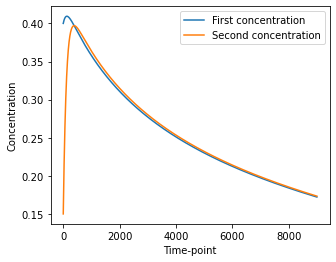

In [83]:
# Uncomment the following line if you have not computed yet A and I
# A, I = answer_results(4, A=0.4, I=0.15, dt=dt, k=k, tau=tau, n=n)
plot_concentration_1cell(A, I)

## 4. Introduction to functions
You have seen some functions previously, for example the functions `print`, `eval`, `input` or `range` for example which are `builtin` functions, functions that are "in" Python. You've also seen the functions `anwser`, `hint`, `da_alone`, `da` or `di` which are function that have been imported (here via the commands `from Resources.UsefulFunctions import *` and `from Resources.Answers import answer, hint`)

A function is a piece of code that can be called at any time once defined. Functions are especially useful as you may have notice, when you know that you will want to call a piece of code multiple times, maybe with different inputs. For example, you called the function `print` with many different inputs.

Functions are extremely powerful and can be manipulated in an extremely precise way. You can find all about that [there](https://docs.python.org/3/tutorial/controlflow.html#defining-functions).

That being said, the main idea is that a function can be defined the following way:
```python
def fib(n):
    """
    This function returns the highest fibonacci
    number which is lower than n.
    
    Args:
        n (int): upper boundary for the fibonacci number
    
    Returns:
        (int): higher fibo number lower than n
    """
    a, b = 0, 1
    while b < n:
        a, b = b, a+b
    return a
```
As explained, this function has to do with Fibonacci numbers (they are pretty cool, you can find out more [here](https://en.wikipedia.org/wiki/Fibonacci_number)).

The first line:
```python
def fib(n):
```
is the name of the function (`fib`) followed by the sequence of arguments of the function (here there is only one: `n`).

The following lines:
```python
    """
    This function returns the highest fibonacci
    number which is lower than n.
    
    Args:
        n (int): upper boundary for the fibonacci number
    
    Returns:
        (int): higher fibo number lower than n
    """
```
are the description of the function.

Then, there is the code of the function:
```python
    a, b = 0, 1
    while b < n:
        a, b = b, a+b
```

And finally the last last line:
```python
    return a
```
which informs the program what will the function return.

You can run the code bellow to define the function and to test it:

In [82]:
def fib(n):
    """
    This function returns the highest fibonacci
    number which is lower than n.
    
    Args:
        n (int): upper boundary for the fibonacci number
    
    Returns:
        (int): higher fibo number lower than n
    """
    a, b = 0, 1
    while b<n:
        a, b = b, a+b
    return a

fib(2000)
fib?

### Exercice 6
Write a function that returns the lists of concentrations `A` and `I` given the parameters `dt`, `k`, `tau` and `n` and the initial concentrations `a` and `i`.

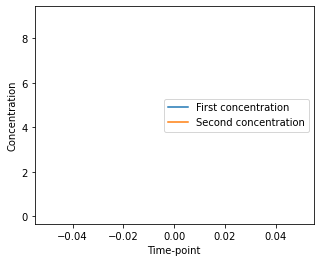

In [88]:
def compute_AI(): # Don't forget to add arguments
    A, I = [a], [i]
    # Do something here
    return A, I

A, I = compute_AI()
plot_concentration_1cell(A, I)

### Exercice 7
**(With an intermezzo about file manipulation)**

You can play with the different parameters to see how the concentration dynamics change according to these parameters.

Here we would like you to systematically try different parameters and save the produced plots as png files with names containing the parameter values (for example `'test_a0.4_i0.15_dt0.001_k-0.005_tau0.1.png'`).

To save the produced plots, you can use the argument `save_path` of the function `plot_concentration_1cell`.
If you set its value to the file name and path you want to create, it will save it there under its name.

Before being able to do so, you might need some information about how to manipulate strings.
In the previous exercices you might have seen that it is possible to insert values from variables within a string using the curved brackets `{` and `}`.

Simply putted, the way it works is by putting the character `f` before your string and then everything within curved brackets will be transformed in string if possible.
For example:
```python
f'test_a{A[0]}_i{I[0]}_dt{dt}'
```
will produce the following string:
```python
'test_a0.4_i0.15_dt0.001'
```
Note that if the `f` is not in front of the string, the curved brackets will be interpreted as normal characters.

**For more on string manipulation, you can read [there](https://docs.python.org/3/tutorial/inputoutput.html#input-and-output)**

In [71]:
print(f'test_a{A[0]}_i{I[0]}_dt{dt}')
print('test_a{A[0]}_i{I[0]}_dt{dt}')

test_a0.4_i0.15_dt0.001
test_a{A[0]}_i{I[0]}_dt{dt}


#### Avoiding cramping up you current folder
If you want to be a little bit cleaner, you can create a folder in which you will save your images.

You can create such a folder directly in python using `Path` from the `pathlib` library and the command:
```python
Path.mkdir('<folder_name>')
```
For example, to crate a folder named `question_6` one could run the command
```python
Path.mkdir('question_6')
```

Though, if the folder already exists, the command line will not work and stop the notebook from running.
To avoid such a problem, it is possible to check whether the folder already exists using the method `exists` of `Path` as shown below.

Let's create the folder `question_6`:

In [72]:
from pathlib import Path
folder = Path('question_6')
if not folder.exists():
    Path.mkdir(folder)

#### Path manipulation
Some of you might already be aware that playing with path can be a pain.
The problem comes from the fact that Windows has a different way to represent a path to a folder than Linux and MacOs.

> **_Side Note: what's a path?!_**
> 
> In a computer the folders and files are organized hierarchically.
> What it means is that each file or folder except for one, the root, is in a folder.
> For example, the folder you created earlier (`question_6`) is itself in a folder.
> 
> To access a file or folder, it is sometimes necessary to know the sequence of folders it is in so there is no ambiguity for the computer.
> The sequence of folders a folder or a file belongs to is the **path** and it can be represented as a string.
> For example, you can call the function `Path.cwd` (for current working directory).
> To query the list of directories your notebook is running in:

In [73]:
print('Our current path:')
print(Path.cwd())

Our current path:
/Users/guignardl/dvlp/Perso/CenTuri-Course-2022


> You can maybe see that the folders are separated by a `/` (or a `\` for Windows).
> This difference between Linux or MacOs and Windows has been quite a source of trouble, some of you might have experienced it.

Now, to save an image in the folder `'question_6'`, as we would like to do, we just need to concatenate the image name to the folder name:
```python
folder / 'test_a0.4_i0.15_dt0.001.png'
```

Note that the `/` in this case is a concatenation operator specific to the objects of the `path` library. The operator concatenates two `Path` or a `Path` and a `str` putting the operating specific folder separator (
`/` or `\`).

**More info about the `pathlib` can be found [there](https://docs.python.org/3/library/pathlib.html)**

In [74]:
## folder is the path previously created
# Concatenation of two Paths
print(folder / Path('test_a0.4_i0.15_dt0.001.png'))
# Concatenation of a Path and a str (same result)
print(folder / 'test_a0.4_i0.15_dt0.001.png')

question_6/test_a0.4_i0.15_dt0.001.png
question_6/test_a0.4_i0.15_dt0.001.png


Now we can *cleanly* answer question 6.
Let assumes that we want the following values:
- `tau` changes from `0.05` to `3` and that we want `5` values within that interval
- `k` changes from `-1` to `1` and that we also want `5` values within that interval
- and a fixed `dt=0.01`

**Write some lines of code to compute and save the requested plots**

Note: you can use the function `np.linspace` to generate the desired values

In [75]:
import numpy as np
for test_tau in np.linspace(.05, 1, 5):
    for test_k in np.linspace(-1, 1, 5):
        A, I = answer_results(4, A=0.4, I=0.15, dt=dt, k=test_k, tau=test_tau, n=n)
        plot_concentration_1cell(A, I,
                                 save_path=folder / f'k{test_k}_tau{test_tau}.png')

An interesting configuration where we can see some oscillations:
- `dt=0.01`
- `k=0.05`
- `tau=2`

You can manually change the parameters to try to find other *weird* configurations

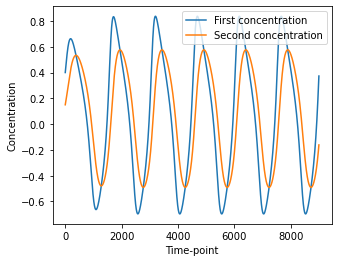

In [86]:
A, I = answer_results(4, A=0.4, I=0.15, dt=.01, k=.05, tau=2, n=n)
plot_concentration_1cell(A, I)

### Exercice 8
For this exercice, we will discuss about file manipulation, in other words how to move files automatically.

**Attention here! Proceed with caution for this exercice but also in general. Files removed using Python (or the shell for example) do not end up in the trash but are directly removed!**

In this exercice we would like to sort the files created in the previous exercice

# Turing patterns
You can find here a simple, naive implementation of the Turing patterns.

There are few cosmetic deviations from a normal implementation (especially the variable dt).

For info: [@guignardlab](https://twitter.com/guignardlab)

In [ ]:
import numpy as np
from colorsys import rgb_to_hsv, hsv_to_rgb
from matplotlib import pyplot as plt
from matplotlib import animation, rc
from matplotlib.colors import LinearSegmentedColormap
from IPython.display import HTML
from scipy.signal import convolve2d
from scipy.stats import logistic
%matplotlib inline

## CenTuri "colormap"
RGB = np.array([0, 137, 179])/255
HSV = rgb_to_hsv(*RGB)
colors = [hsv_to_rgb(HSV[0], 0, HSV[1]), hsv_to_rgb(HSV[0], 1, HSV[1])]
cmap = LinearSegmentedColormap.from_list("CenTuri_cmap", colors)

# Useful functions
def norm_array(array, mask, th=None, func=None):
    """
    Normalizing an array between 0 and 1
    
    Parameters
    ----------
    array : ndarray of shape 2 or 3
        The array to be normalize. If the shape of the
        array is 3, each 2D arrays will be normalized
        independently along the axis 0
    mask : ndarray of with the same shape of array
        Puts to 0 values that are outside of the mask
    th : float
        any value bellow the threshold are put to 0
    func : function
        a function that will be applied to the normalized
        array if th is None
    Returns
    -------
    out : ndarray
        The normalized array
    """
    if len(array.shape)==2:
        vals_to_norm = array[mask!=0]
        out = (array-vals_to_norm.min())/(vals_to_norm.max() - vals_to_norm.min())
        out[mask==0] = 0
    else:
        vals_to_norm = array[mask!=0]
        out = (array-vals_to_norm.min(axis=0))/(vals_to_norm.max(axis=0) - vals_to_norm.min(axis=0))
        out[mask==0] = 0
    if th:
        out[out<th] = 0
    elif func:
        out = func(out)
    return out

def outer_circle(XY, centre, r):
    """
    From an np.mgrid `XY`, builds a mask that is True within
    the circle centered in `centre` and of radius `r`

    Parameters
    ----------
    XY : 2D mgrid
        The support of the mask
    centre: tuple of floats
        The coordinates of the centre of circle
    r: float
        Radius of the circle
    
    Returns
    -------
    out : ndarray of the same shape of XY
        The mask
    """
    return (XY[0]-centre[0])**2 + (XY[1]-centre[1])**2 < r**2

We have an activator $A$ and an inhibitor $I$ which interact as follow:

$A \rightarrow A$

$A \rightarrow I$

$I \dashv A$

Resulting in the following equations:

$\frac{\delta A}{\delta t} = k_{AA} A - k_{IA} I$

$\frac{\delta I}{\delta t} = k_{AI} A - k_{II} I$

In [ ]:
# Functions for the evolution of A and I
dA_dt = lambda AI: (kAA * AI[0] - kIA * AI[1])
dI_dt = lambda AI: (kAI * AI[0] - kII * AI[1])

def dAI_dt(AI):
    return dA_dt(AI), dI_dt(AI)

The antagonist (resp. inhibitor) diffuses according to a diffusion coefficient $\mu$ (resp. $\nu$) to the 4 neighboring cells. The diffusion is modeled as follow:

$\frac{\delta A_{x, y}}{\delta x \delta y} = \mu(A_{x+\delta x, y} + A_{x-\delta x, y} + A_{x, y+\delta y} + A_{x, y-\delta y} - 4A_{x, y})$

$\frac{\delta I_{x, y}}{\delta x \delta y} = \nu(I_{x+\delta x, y} + I_{x-\delta x, y} + I_{x, y+\delta y} + I_{x, y-\delta y} - 4I_{x, y})$

In [ ]:
def diffusion(array, weights):
    """
    Computes the diffusion in 2D given a set of weights.
    The weights are useful for the average at the borders
    of the region considered.
    If this is the region considered:
    [[ 0 0 0 0 0 0 ]
     [ 0 0 1 1 0 0 ]
     [ 0 1 1 1 1 0 ]
     [ 0 1 1 1 1 0 ]
     [ 0 0 1 1 0 0 ]
     [ 0 0 0 0 0 0 ]]
    the weights should be the number of neighbors
    within the mask:
    [[ 0 0 0 0 0 0 ]
     [ 0 0 2 2 0 0 ]
     [ 0 2 4 4 2 0 ]
     [ 0 2 4 4 2 0 ]
     [ 0 0 2 2 0 0 ]
     [ 0 0 0 0 0 0 ]]
    this can be obtained by convolving
    the mask with the following kernel:
    [[ 0 1 0 ]
     [ 1 0 1 ]
     [ 0 1 0 ]]
    
    Parameters
    ----------
    array : ndarray of floats shape NxM
        The array with the initial concentrations
    weights : ndarray of floats of shape NxM
        The weights for the diffusion
    
    Returns
    -------
    out : ndarray of shape NxM
        the initial array after diffusion
        (without taking into account the
        diffusion coefficients)
    """
    kernel = [[0, 1, 0],
              [1, 0, 1],
              [0, 1, 0]]
    out = convolve2d(array, kernel, boundary='symm', mode='same')
    out -= array * weights
    return out

Then we combine the activation/inhibition and diffusion and we get:

$\frac{\delta A_{x, y}}{\delta t\delta x \delta y} = k_{f} A - k_{r} I + \mu(A_{x+\delta x, y} + A_{x-\delta x, y} + A_{x, y+\delta y} + A_{x, y-\delta y} - 4A_{x, y})$

$\frac{\delta I_{x, y}}{\delta t\delta x \delta y} = k_{e} A - k_{d} I + \nu(I_{x+\delta x, y} + I_{x-\delta x, y} + I_{x, y+\delta y} + I_{x, y-\delta y} - 4I_{x, y})$

In [ ]:
def dAI_dtxy(A, I, dt, dx, dy, mu, nu, weights):
    """
    Integrating activation, inhibition and diffusion
    
    Parameters
    ----------
    A : ndarray of floats of shape NxM
        The array containing the initial
        concentration of activators
    I : ndarray of floats of shape NxM
        The array containing the initial
        concentration of inhibitors
    dt : float
        time increment
    dx : float
        size of a pixel in `A` and `I` in µm
        along the `x` dimension
    dy : float
        size of a pixel in `A` and `I` in µm
        along the `y` dimension
    mu : float
        diffusion coefficient for the activator
    nu : float
        diffusion coefficient for the inhibitor
    weights : ndarray of shape NxM
        weights for the diffusion average related
        to the mask considered
    
    Returns
    -------
    A : ndarray of floats of shape NxM
        The array containing the new
        concentration of activators after
        a time dt
    I : ndarray of floats of shape NxM
        The array containing the new
        concentration of inhibitors after
        a time dt
    """
    diffusion_A = diffusion(A, weights)/(dx*dy)
    diffusion_I = diffusion(I, weights)/(dx*dy)
    new_A = A + dt*(dA_dt([A, I]) + mu*diffusion_A)
    new_I = I + dt*(dI_dt([A, I]) + nu*diffusion_I)
    A = new_A
    I = new_I
    A[mask==0] = 0
    I[mask==0] = 0
    return A, I

Carefully chosen parameters, thanks to [Alice Gros](https://twitter.com/_AliceGros) in [@Equipe_lenne](https://twitter.com/Equipe_lenne)

In [ ]:
kAA, kIA, kAI, kII = 10, 12, 31, 20
mu = 0.001
nu = 0.025

# voxel size in the x and y dimensions
dx = dy = 0.02

# step size of time in seconds
dt = 0.000001
# because the timestep has to be smaller
# at the begining we use a variable dt
dt_final = 0.001
variable_dt = np.linspace(dt, dt_final, n)

# Number of iterations
n = 20000
# Number of timepoints to save
nb_times_im = 200

Random initialisation of the circle

Computation of the weight mask

Initialisation of the final array which will contain our data

In [ ]:
# size of the grid onto which the model is run
grid_size = 100
# centre and radius of the circle onto wich
# the model is run
circle_center = [49, 49]
radius = 45

# randomizing the initial state
# change the seed from 1 to any other value
# to observe different results
generator = np.random.default_rng(1)
init_A = generator.uniform(size=(grid_size, grid_size))
init_I = generator.uniform(size=(grid_size, grid_size))

# building the mask to get a circle
# together with the weights related
# to this specific mask.
mask = (outer_circle(np.mgrid[:grid_size, :grid_size], circle_center, r=radius)).astype(np.uint8)
kernel = [[0, 1, 0],
          [1, 0, 1],
          [0, 1, 0]]
weights = convolve2d(mask, kernel, boundary='symm', mode='same')

# Masking the initial position and
# copying it for safety
init_A[mask==0] = 0
init_I[mask==0] = 0
A = init_A.copy()
I = init_I.copy()

# ndarray in which will be stored the results
final_A = np.zeros(A.shape + (nb_times_im+1,))

Running the simulation

In [ ]:
for i in range(n):
    if variable_dt is not None:
        dt = variable_dt[i]
    if i%(n//nb_times_im)==0:
        final_A[...,int(i//(n/nb_times_im))] = A
    A, I = dAI_dtxy(A, I, dt, dx, dx, mu, nu, weights)
    
final_A[...,-1] = A

In [ ]:
# Normalizing the final array using a logistic function
# centered in 0.5 to have values between 0 and 1 but
# a sharper slope between low and high expression
normed_array = norm_array(final_A, mask, func=lambda x:logistic.cdf(x, .5, .05))

Plotting the results

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.axis('off')
im = ax.imshow(init_A, cmap=cmap)
fig.tight_layout()

def init():
    im.set_data(init_A)
    return(im,)

def animate(i):
    im.set_data(normed_array[...,i])
    return(im,)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=nb_times_im, interval=25, 
                               blit=True)

HTML(anim.to_jshtml())

In [ ]:
anim.save('turing.gif', dpi=50)